In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import folium
import numpy as np
import matplotlib as mpl
from folium.plugins import MarkerCluster
import json
import fiona 
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.ticker as ticker
import pandas as pd
from plotly import graph_objs as go
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import WAZE data
df=pd.read_csv('MORA_alerts.csv', encoding="ISO-8859-1")

In [3]:
#opening entrances shapefile
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
entrances = gpd.read_file('MORA Park Entrances.kml', driver='KML')

In [4]:
#converting WAZE data frame into GeoDataFrame with geometry point 
alertPoints = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.location_lon, df.location_lat),crs={'init' :'epsg:4326'})
alertPoints=alertPoints.to_crs(epsg=4326)

In [5]:
#clipping WAZE points to those within the entrance
MORAalerts=gpd.clip(alertPoints,entrances)

In [6]:
#Spatial join to tie entrance name to alert 
alerts_with_entrance=gpd.sjoin(MORAalerts,entrances,how="inner", op='intersects')

In [7]:
alerts_with_entrance.to_csv("alerts_clippedToEntrance.csv",index=False,mode='w')

In [8]:
#Removing Road Closure Alerts 
nonclosureAlerts = alerts_with_entrance.loc[df.sub_type != 'ROAD_CLOSED_EVENT']

In [9]:
nonclosureAlerts.to_csv("alerts_clippedToEntrancewOutClosures.csv",index=False,mode='w')

In [10]:
#Number of Total Alerts at Each entrance
df_ent_grouped=alerts_with_entrance.groupby(['Name']).count()
df_ent_grouped=df_ent_grouped.reset_index()
df_ent_grouped=df_ent_grouped[['Name','alert_char_crc']].sort_values(by='Name')
df_ent_grouped.rename(columns={'alert_char_crc': 'Number of Alerts'}, inplace=True)

In [11]:
#Number of Total Alerts at Each entrance
df_ent_groupedNOclosed=nonclosureAlerts.groupby(['Name']).count()
df_ent_groupedNOclosed=df_ent_groupedNOclosed.reset_index()
df_ent_groupedNOclosed=df_ent_groupedNOclosed[['Name','alert_char_crc']].sort_values(by='Name')
df_ent_groupedNOclosed.rename(columns={'alert_char_crc': 'Number of Alerts (excluding Closures)'}, inplace=True)

In [12]:
withWithoutClosures = pd.merge(df_ent_grouped, df_ent_groupedNOclosed, on='Name')

In [13]:
df2 = pd.DataFrame({"Name":['Mowich Lake', 'Carbon River'],
                    "Number of Alerts":[24, 36],
                   "Number of Alerts (excluding Closures)":[0,0]})
alertsComparison=withWithoutClosures.append(df2)
alertsComparison.rename(columns={'Name': 'Entrance Name'}, inplace=True)

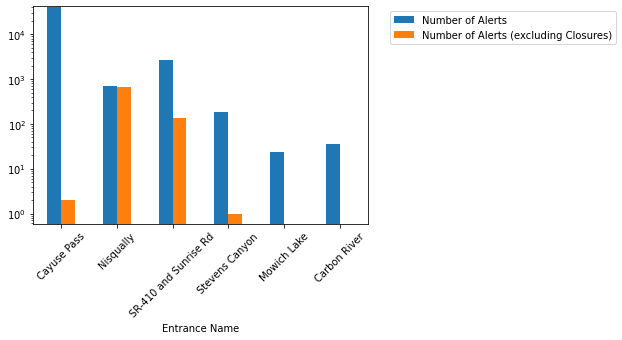

In [14]:
alertsComparison.plot.bar(x='Entrance Name', logy=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0,42000)
plt.xticks(rotation = 45)
plt.show()

# Types of Alerts

In [16]:
#Total types of main alerts 
alerts_with_entrance.alert_type.value_counts()

ROAD_CLOSED      44434
JAM                796
WEATHERHAZARD       22
Name: alert_type, dtype: int64

# Alert Sub Types

In [17]:
#Counts of alert subtypes
alerts_with_entrance.sub_type.value_counts()

ROAD_CLOSED_EVENT                 44434
JAM_STAND_STILL_TRAFFIC             567
JAM_HEAVY_TRAFFIC                   149
JAM_MODERATE_TRAFFIC                 25
HAZARD_ON_SHOULDER_CAR_STOPPED       10
HAZARD_ON_ROAD_CONSTRUCTION           9
HAZARD_ON_ROAD_OBJECT                 1
HAZARD_ON_ROAD_CAR_STOPPED            1
HAZARD_ON_SHOULDER_ANIMALS            1
Name: sub_type, dtype: int64

In [18]:
#Separating the different kinds of alerts into their own data frames
df_accidents = alerts_with_entrance.loc[df['alert_type']=='ACCIDENT']
df_accidents = df_accidents.reset_index()
df_jams = alerts_with_entrance.loc[df['alert_type']=='JAM']
df_jams = df_jams.reset_index()
df_shoulder = alerts_with_entrance.loc[df['sub_type']=='HAZARD_ON_SHOULDER_CAR_STOPPED']
df_shoulder = df_shoulder.reset_index()

In [19]:
#Counting the types of traffic jams at each Entrance SOMETHING WRONG CHECK AGAIN
entrances = ['Cayuse Pass', 'SR-410 and Sunrise Rd', 'Nisqually', 'Stevens Canyon','Carbon River','Mowich Lake']   

entrances_df_jams = pd.DataFrame({'Name':entrances})

for x in df_jams.sub_type.unique():
    temp_df = df_jams.loc[df_jams['sub_type']==x]
    if str(x) =='nan':
        x="No Details Captured"
        temp_df = df_accidents.loc[df_jams['sub_type'].isin(['JAM_MODERATE_TRAFFIC','JAM_HEAVY_TRAFFIC', 'JAM_STAND_STILL_TRAFFIC'])==False]
        

    print(x, ": ", len(temp_df))
    
    temp_df_entrances = temp_df.groupby(['Name']).count()
    temp_df_entrances= temp_df_entrances.reset_index()

    temp_df_entrances = temp_df_entrances[['Name','alert_char_crc']]
    
    temp_df_entrances['alert_char_crc']=temp_df_entrances['alert_char_crc']
    temp_df_entrances.Name = temp_df_entrances.Name.astype("category")
    temp_df_entrances.Name.cat.set_categories(entrances, inplace=True)
    temp_df_entrances = temp_df_entrances.sort_values('Name')
    temp_df_entrances= temp_df_entrances.reset_index()
    entrances_df_jams[x] =temp_df_entrances[['alert_char_crc']] 

entrances_df_jams.fillna(0)

JAM_STAND_STILL_TRAFFIC :  567
JAM_HEAVY_TRAFFIC :  149
No Details Captured :  0
JAM_MODERATE_TRAFFIC :  25


,Name,JAM_STAND_STILL_TRAFFIC,JAM_HEAVY_TRAFFIC,No Details Captured,JAM_MODERATE_TRAFFIC
0,Cayuse Pass,108.0,14.0,0.0,4.0
1,SR-410 and Sunrise Rd,459.0,135.0,0.0,21.0
2,Nisqually,0.0,0.0,0.0,0.0
3,Stevens Canyon,0.0,0.0,0.0,0.0
4,Carbon River,0.0,0.0,0.0,0.0
5,Mowich Lake,0.0,0.0,0.0,0.0


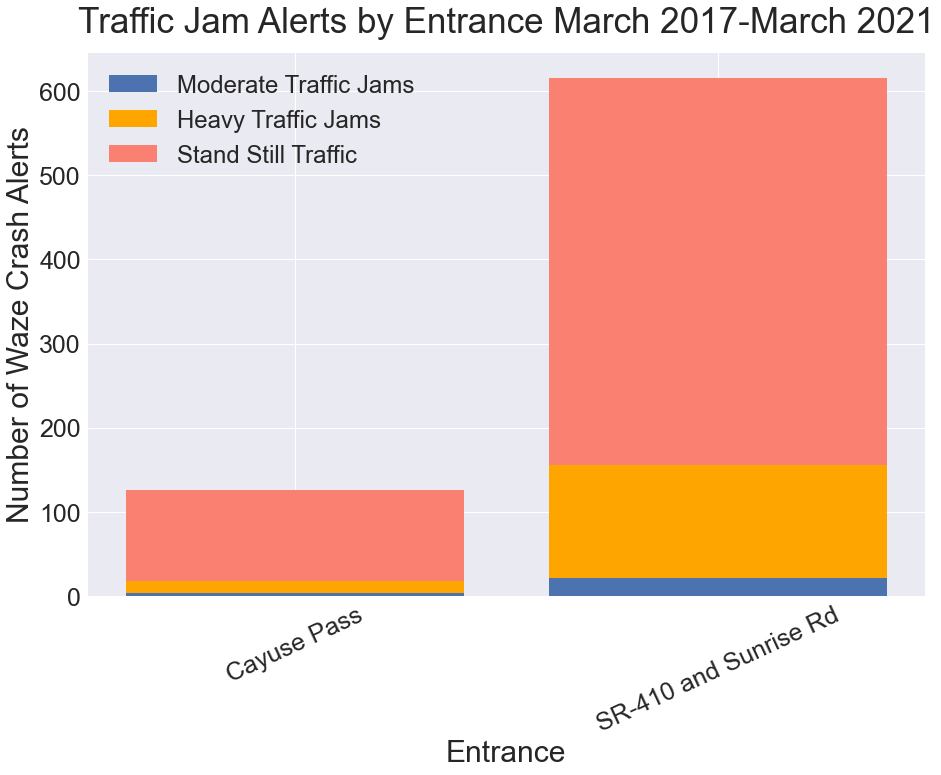

In [20]:
plt.style.use('seaborn')
tick_spacing = 1

entrances = ['Cayuse Pass', 'SR-410 and Sunrise Rd', 'Nisqually', 'Stevens Canyon','Carbon River','Mowich Lake']  

fig, ax = plt.subplots(1,1,figsize=(15,10))
ax.bar(entrances,entrances_df_jams['JAM_MODERATE_TRAFFIC'], label = 'Moderate Traffic Jams', linewidth=1)
ax.bar(entrances,entrances_df_jams['JAM_HEAVY_TRAFFIC'], label = 'Heavy Traffic Jams', 
       bottom = entrances_df_jams['JAM_MODERATE_TRAFFIC'] , linewidth=1, color = 'orange')
ax.bar(entrances,entrances_df_jams['JAM_STAND_STILL_TRAFFIC'], label = 'Stand Still Traffic', 
       bottom = entrances_df_jams['JAM_HEAVY_TRAFFIC']+entrances_df_jams['JAM_MODERATE_TRAFFIC'] , linewidth=1, color = 'salmon')

ax.set_title('Traffic Jam Alerts by Entrance March 2017-March 2021',fontsize= 35, pad = 20) # title of plot

ax.set_xlabel('Entrance',fontsize = 30) #xlabel
ax.set_ylabel('Number of Waze Crash Alerts', fontsize = 30)#ylabel
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', which='major', labelsize=25,rotation = 25)
ax.tick_params(axis='y', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.grid('on')
plt.legend(fontsize = 24)
plt.show()

In [21]:
nonclosureAlerts.sub_type.value_counts()

JAM_STAND_STILL_TRAFFIC           567
JAM_HEAVY_TRAFFIC                 149
JAM_MODERATE_TRAFFIC               25
HAZARD_ON_SHOULDER_CAR_STOPPED     10
HAZARD_ON_ROAD_CONSTRUCTION         9
HAZARD_ON_ROAD_OBJECT               1
HAZARD_ON_SHOULDER_ANIMALS          1
HAZARD_ON_ROAD_CAR_STOPPED          1
Name: sub_type, dtype: int64

In [ ]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df_ent_groupedNOclosed.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df_ent_groupedNOclosed.Name, df_ent_groupedNOclosed.alert_char_crc],
               fill_color='lavender',
               align='left'))
])

fig.show()

AttributeError: 'DataFrame' object has no attribute 'alert_char_crc'

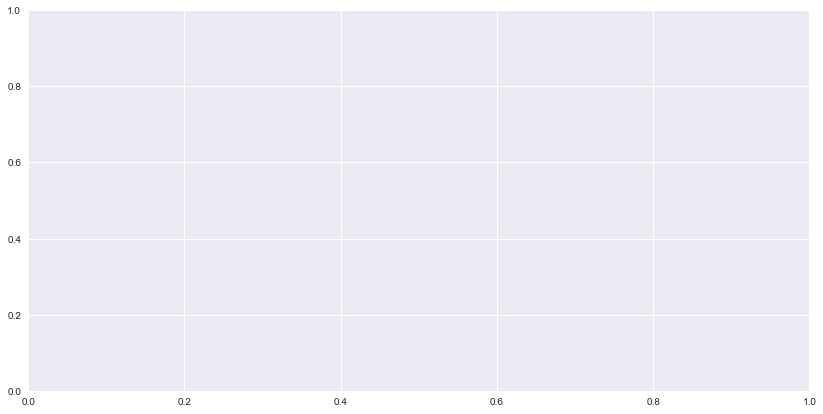

In [22]:
plt.style.use('seaborn')

tick_spacing = 3 
fig,ax = plt.subplots(1,1, figsize=(14, 7))
ax.bar(df_ent_groupedNOclosed.Name, df_ent_groupedNOclosed.alert_char_crc, linewidth=4)
ax.set_title('Waze Alerts at Entrances 2017-2021 (excluding closures)', fontsize=20)

ax.set_xlabel('Entrance Name', fontsize=20)
ax.set_ylabel('Number of Waze Alerts', fontsize=20)
ax.grid('off')

plt.show()

In [23]:
#Adding IRMA traffic counts to # alerts dataframe without closed 
d = {'Name': ['Nisqually','Stevens Canyon','Cayuse Pass','SR-410 and Sunrise Rd','Mowich Lake','Carbon River'], 'IRMA Counts': [1087426, 433493, 472187, 771349, 553362, 111790]}
IRMA = pd.DataFrame(data=d)
wazeIrma=df_ent_groupedNOclosed.join(IRMA.set_index('Name'), on='Name')
wazeIrma

,Name,Number of Alerts (excluding Closures),IRMA Counts
0,Cayuse Pass,2,472187
1,Nisqually,682,1087426
2,SR-410 and Sunrise Rd,133,771349
3,Stevens Canyon,1,433493


In [24]:
wazeIrma['WAZE percent'] = (wazeIrma['alert_char_crc'] / wazeIrma['alert_char_crc'].sum()) * 100
wazeIrma['IRMA percent'] = (wazeIrma['IRMA Counts'] / wazeIrma['IRMA Counts'].sum()) * 100
wazeIrma  

KeyError: 'alert_char_crc'

In [25]:
#opening link locations shapefile
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
links = gpd.read_file('FOTSCLBS Corresponding Polygons.kml', driver='KML')

In [26]:
#clip alerts to LBS measurement points and join 
MORAalertsLBS=gpd.clip(alertPoints,links)
alertsAlongLinks=gpd.sjoin(MORAalertsLBS,links,how="inner", op='intersects')

In [27]:
#Number of Total Alerts at Each link
linkAlerts=alertsAlongLinks.groupby(['Name']).count()
linkAlerts=linkAlerts.reset_index()
linkAlerts=linkAlerts[['Name','alert_char_crc']].sort_values(by='Name')

In [28]:
#Adding FOTSC & LBS traffic counts to # alerts dataframe
d = {'Name': ['East/West Nisqually','SR 410 N of Sunrise Rd','SR 410 S of Sunrise Rd','Sunrise Rd. W of SR 410','West/East Stevens Canyon Rd. West of SR123'],
     'FOTSC Counts': [275453, 337421, 291879, 163190, 137699],
    'LBS Counts':[16641, 14844, 11013, 10399, 8056]}
flows = pd.DataFrame(data=d)
alertsAndFlows=linkAlerts.join(flows.set_index('Name'), on='Name')

In [29]:
#Calculating Percentages
alertsAndFlows['WAZE percent'] = (alertsAndFlows['alert_char_crc'] / alertsAndFlows['alert_char_crc'].sum()) * 100
alertsAndFlows['LBS percent'] = (alertsAndFlows['FOTSC Counts'] / alertsAndFlows['FOTSC Counts'].sum()) * 100
alertsAndFlows['FOTSC percent'] = (alertsAndFlows['LBS Counts'] / alertsAndFlows['LBS Counts'].sum()) * 100
alertsAndFlows

,Name,alert_char_crc,FOTSC Counts,LBS Counts,WAZE percent,LBS percent,FOTSC percent
0,East/West Nisqually,730,275453,16641,19.671248,22.846998,27.301363
1,SR 410 N of Sunrise Rd,1,337421,14844,0.026947,27.986832,24.353190
2,SR 410 S of Sunrise Rd,2454,291879,11013,66.127728,24.209425,18.068020
3,Sunrise Rd. W of SR 410,180,163190,10399,4.850445,13.535527,17.060686
4,West/East Stevens Canyon Rd. West of SR123,346,137699,8056,9.323632,11.421218,13.216741


In [30]:
# LBS calculations without road closure
#Removing Road Closure Alerts 
nonclosureAlerts = alertsAlongLinks[df.alert_type != 'ROAD_CLOSED']
#Number of Total Alerts at Each LBS 
LBSnoClosed=nonclosureAlerts.groupby(['Name']).count()
LBSnoClosed=LBSnoClosed.reset_index()
LBSnoClosed=LBSnoClosed[['Name','alert_char_crc']].sort_values(by='Name')
LBSnoClosed
#Adding FOTSC & LBS traffic counts to # alerts dataframe
d = {'Name': ['East/West Nisqually','SR 410 N of Sunrise Rd','SR 410 S of Sunrise Rd','Sunrise Rd. W of SR 410','West/East Stevens Canyon Rd. West of SR123'],
     'FOTSC Counts': [275453, 337421, 291879, 163190, 137699],
    'LBS Counts':[16641, 14844, 11013, 10399, 8056]}
flows = pd.DataFrame(data=d)
alertsAndFlows=LBSnoClosed.join(flows.set_index('Name'), on='Name')
#Calculating Percentages
alertsAndFlows['WAZE percent'] = (alertsAndFlows['alert_char_crc'] / alertsAndFlows['alert_char_crc'].sum()) * 100
alertsAndFlows['FOTSC percent'] = (alertsAndFlows['LBS Counts'] / alertsAndFlows['LBS Counts'].sum()) * 100
alertsAndFlows['LBS percent'] = (alertsAndFlows['FOTSC Counts'] / alertsAndFlows['FOTSC Counts'].sum()) * 100
alertsAndFlows

,Name,alert_char_crc,FOTSC Counts,LBS Counts,WAZE percent,FOTSC percent,LBS percent
0,East/West Nisqually,683,275453,16641,84.529703,27.301363,22.846998
1,SR 410 N of Sunrise Rd,1,337421,14844,0.123762,24.353190,27.986832
2,SR 410 S of Sunrise Rd,3,291879,11013,0.371287,18.068020,24.209425
3,Sunrise Rd. W of SR 410,120,163190,10399,14.851485,17.060686,13.535527
4,West/East Stevens Canyon Rd. West of SR123,1,137699,8056,0.123762,13.216741,11.421218


In [31]:
#working with full park shape 
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
outline = gpd.read_file('ParkOutline.kml', driver='KML')
MORAparkAlerts=gpd.clip(alertPoints,outline)

In [32]:
#creating quality index and adding 3 levels 
MORAparkAlerts['Quality']=(MORAparkAlerts['reliability']+MORAparkAlerts['report_rating'])
bins = [0, 7, 11, 16]
names = ['Low', 'Medium', 'High']

MORAparkAlerts['qRating'] = pd.cut(MORAparkAlerts['Quality'], bins, labels=names)
MORAparkAlerts.qRating.value_counts()

Low       24417
Medium       64
High          6
Name: qRating, dtype: int64

In [33]:
def label_season(row):
    if row['pub_utc_timestamp_date'].month in [1,2,3,4,11,12] or (row['pub_utc_timestamp_date'].month==5 and row['pub_utc_timestamp_date'].day<=15):
        return('Winter')
    elif row['pub_utc_timestamp_date'].month in [6] or (row['pub_utc_timestamp_date'].month==5 and row['pub_utc_timestamp_date'].day>15) or (row['pub_utc_timestamp_date'].month==10 and row['pub_utc_timestamp_date'].day<15):
        return('Shoulder')
    return('Peak')

In [34]:
MORAparkAlerts['pub_utc_timestamp_date']=pd.to_datetime(df['pub_utc_timestamp'])

In [35]:
MORAparkAlerts['season']=MORAparkAlerts.apply(lambda row:label_season(row), axis=1)
df_season_grouped=MORAparkAlerts.groupby(['season']).count()
df_season_grouped=df_season_grouped.reset_index()
df_season_grouped=df_season_grouped[['season','alert_char_crc']].sort_values(by='season')

In [36]:
MORAparkAlerts['day_of_week'] = MORAparkAlerts['pub_utc_timestamp_date'].dt.day_name()
df_day_grouped=MORAparkAlerts.groupby(['day_of_week']).count()
df_day_grouped=df_day_grouped.reset_index()
df_day_grouped=df_day_grouped[['day_of_week','alert_char_crc']].sort_values(by='day_of_week')

In [37]:
MORAparkAlerts.to_csv("inParkAlerts.csv",index=False,mode='w')

In [38]:
#removing closures and doing weekday and seasonal analysis 
nonclosureAlertsPark = MORAparkAlerts[df.alert_type != 'ROAD_CLOSED']
df_season_groupedNOclosed=nonclosureAlertsPark.groupby(['season']).count()
df_season_groupedNOclosed=df_season_groupedNOclosed.reset_index()
df_season_groupedNOclosed=df_season_groupedNOclosed[['season','alert_char_crc']].sort_values(by='season')


In [39]:
nonclosureAlertsPark.to_csv("inParkAlertswOutClosures.csv",index=False,mode='w')

In [40]:
#day of the week without closed alerts 
df_day_groupedNOclosed=nonclosureAlertsPark.groupby(['day_of_week']).count()
df_day_groupedNOclosed=df_day_groupedNOclosed.reset_index()
df_day_groupedNOclosed=df_day_groupedNOclosed[['day_of_week','alert_char_crc']].sort_values(by='day_of_week')

In [41]:
df_day_groupedNOclosed['Including Closure']=df_day_grouped['alert_char_crc']
df_day_groupedNOclosed

,day_of_week,alert_char_crc,Including Closure
0,Friday,10,3463
1,Monday,8,3414
2,Saturday,41,3360
3,Sunday,42,3609
4,Thursday,8,3380
5,Tuesday,4,4017
6,Wednesday,9,3244


In [42]:
df_season_groupedNOclosed['Including Closure']=df_season_grouped['alert_char_crc']
df_season_groupedNOclosed

,season,alert_char_crc,Including Closure
0,Peak,106,385
1,Shoulder,15,536
2,Winter,1,23566
